## The objectives are as follows:


- Respond to Business Requirement 2:

    - There is a client who wants to know whether a given image of a cherry leaf is healthy or if it has powdery mildew.



## Inputs


    Following sets:

* Train

* Validation

* Test



## Outputs


- Images distribution plot in train, validation, and test set.

- Increasing data diversity by enhancing images.

- Adjusting label predictions during inference by modifying class indices.

- Machine learning model creation and training.

- The trained model should be preserved (saved).

- The learning curve is plotted to visualize the performance of the model.

- Evaluating the model's performance.

- Making predictions on a randomly selected image file.

In [1]:
%pip install -r /workspace/project5/requirements.txt



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
current_dir = os.getcwd()
current_dir



'/workspace/project5/jupyter_notebooks'

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [4]:
work_dir = os.getcwd()
work_dir

'/workspace/project5'

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
import joblib
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras.preprocessing import image
import random
import math



In [6]:
my_data_dir = 'inputs/datasets/cherry-leaves' 
train_path = my_data_dir + '/train'
validation_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'
my_data_dir

version = 'v2'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
  print('There is a version is already available, please create a new version.')
  pass
else:
  os.makedirs(name=file_path)


In [7]:
labels = os.listdir(train_path)

print(f"The project labels are: {labels}")

version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/images_shapes.pkl")
image_shape

The project labels are: ['healthy', 'powdery_mildew']


(64, 64, 3)

### Retrieve the counts of images in the train, validation, and test datasets, and generate a plot displaying the distribution of images across these datasets.

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images


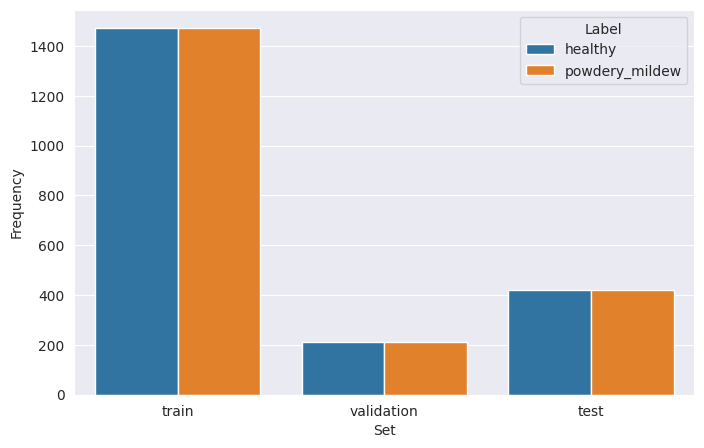

In [8]:
image_counts = []
for folder in ['train', 'validation', 'test']:
    counts = [len(os.listdir(f"{my_data_dir}/{folder}/{label}")) for label in labels]
    image_counts.extend(zip([folder]*len(labels), labels, counts))
    print('\n'.join([f"* {folder} - {label}: {count} images" for label, count in zip(labels, counts)]))

sns.set_style("darkgrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=pd.DataFrame(image_counts, columns=['Set', 'Label', 'Frequency']), x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()
#---------------------------------------------

### Enhancing the training process, by utilizing the ImageDataGenerator library to employ image data augmentation techniques. This will create a varied set of temporary images within the training dataset, thereby enhancing the training process

### Visualize Augmented Training Images##

In [9]:
training_batch_size = 20

augmented_test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_path,                                                                            
    target_size=image_shape[:2],
    color_mode='rgb',
    batch_size=training_batch_size,
    class_mode='binary',
    shuffle=False
)


augmented_train_set = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
).flow_from_directory(
    train_path,
    target_size=image_shape[:2],
    color_mode='rgb',
    batch_size=training_batch_size,
    class_mode='binary',
    shuffle=True
)


augmented_validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(
    validation_path,
    target_size=image_shape[:2],
    color_mode='rgb',
    batch_size=training_batch_size,
    class_mode='binary',
    shuffle=False
)

print("Test class Found {0} images belonging to {1} classes.".format(augmented_test_set.samples, len(augmented_test_set.class_indices)))

print("Train class Found {0} images belonging to {1} classes.".format(augmented_train_set.samples, len(augmented_train_set.class_indices)))

print("Validation class Found {0} images belonging to {1} classes.".format(augmented_validation_set.samples, len(augmented_validation_set.class_indices)))

#---------------------------------------------

Found 844 images belonging to 2 classes.
Found 2944 images belonging to 2 classes.
Found 420 images belonging to 2 classes.
Test class Found 844 images belonging to 2 classes.
Train class Found 2944 images belonging to 2 classes.
Validation class Found 420 images belonging to 2 classes.


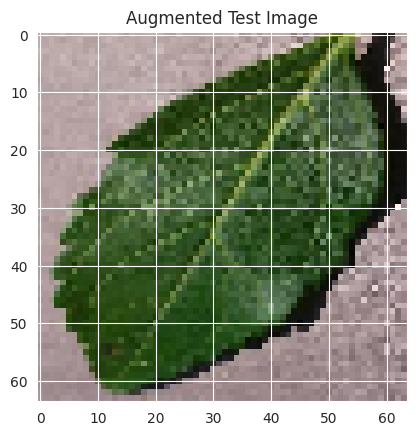

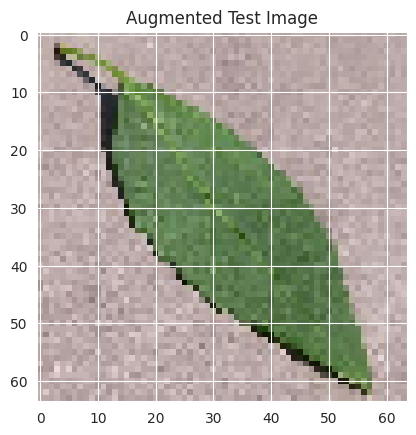

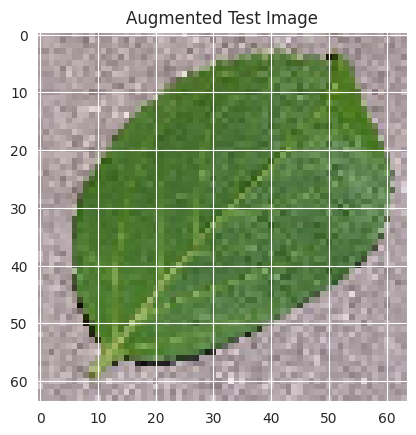

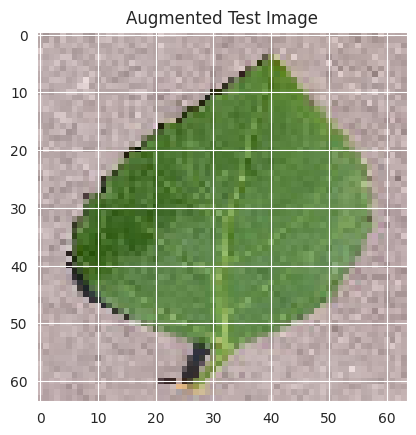

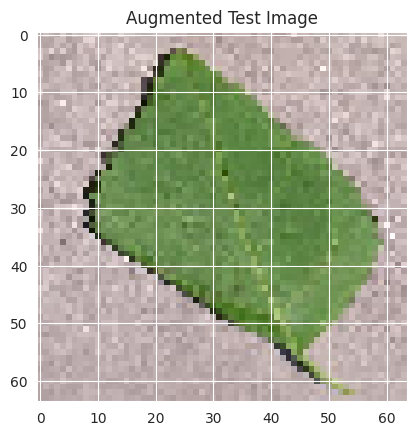

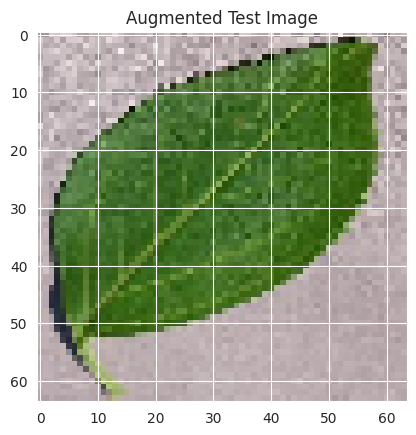

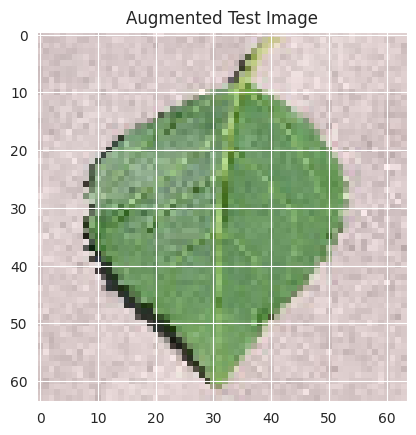

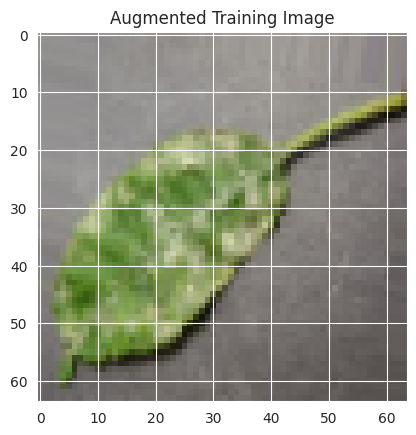

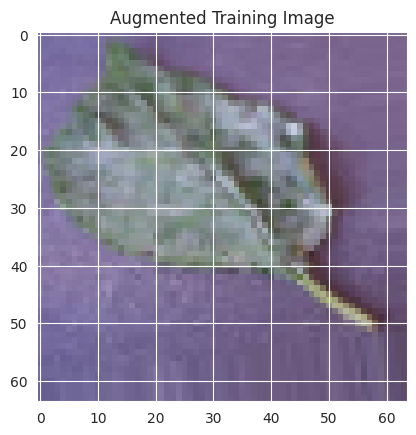

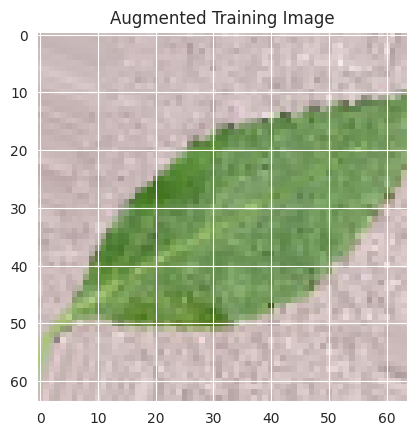

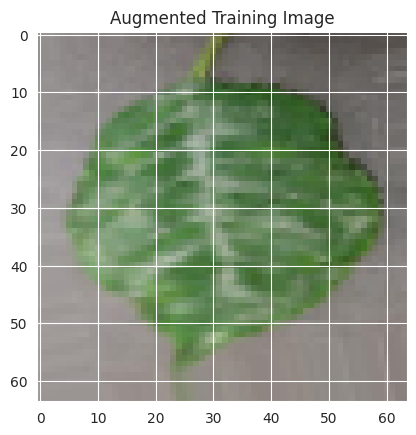

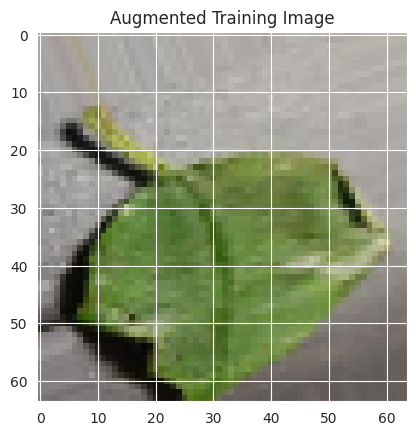

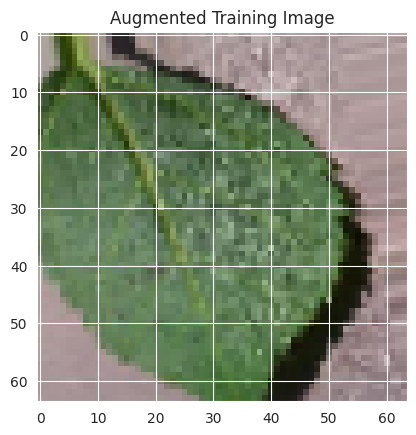

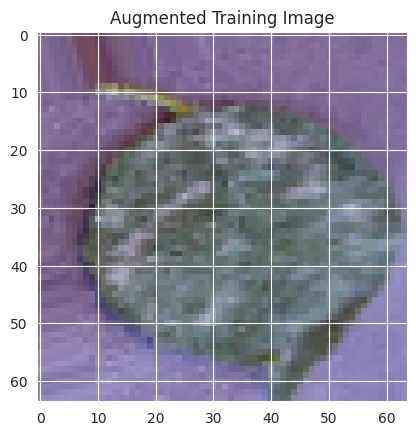

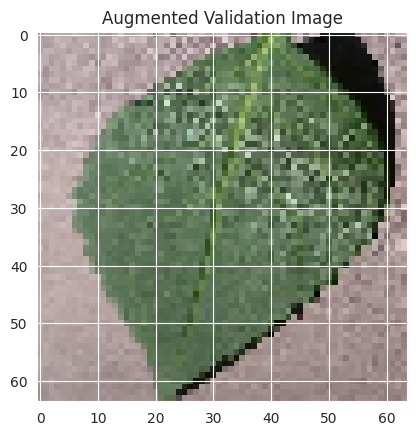

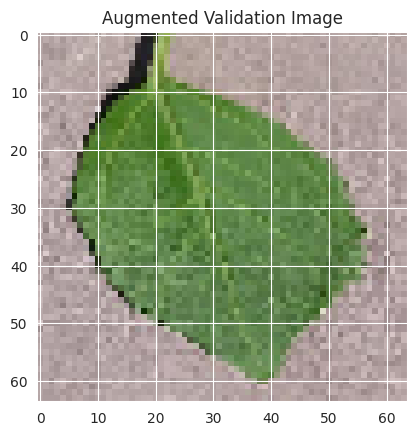

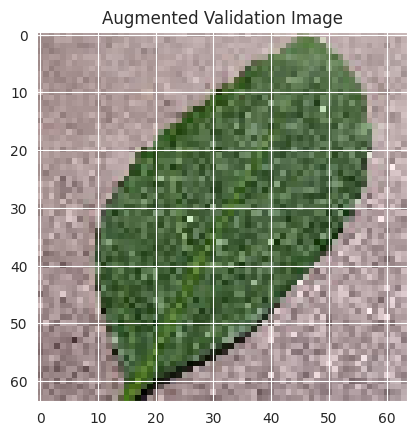

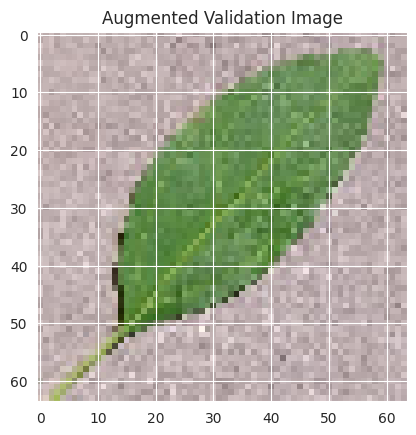

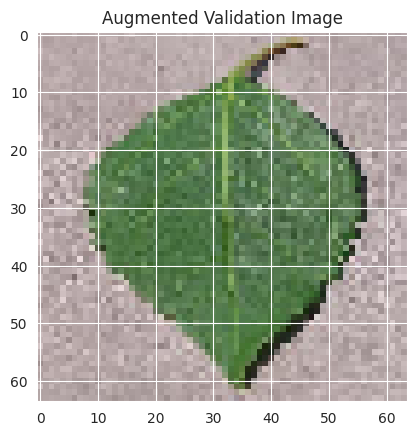

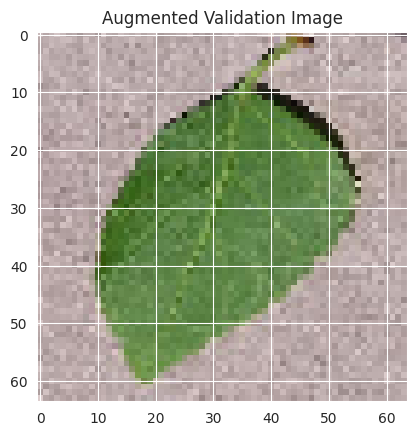

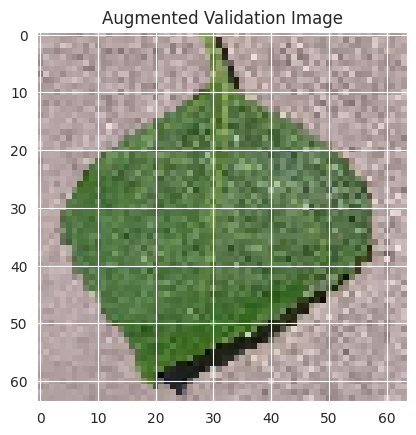

In [10]:
datasets = {
    'Augmented Test Image': augmented_test_set,
    'Augmented Training Image': augmented_train_set,
    'Augmented Validation Image': augmented_validation_set
}

for dataset_name, dataset in datasets.items():
    for _ in range(7):
        img, _ = dataset.next()
        plt.imshow(img[0])
        plt.title(dataset_name)
        plt.show()


In [11]:
joblib.dump(value=augmented_train_set.class_indices,
            filename=f"{file_path}/train_classes_indices.pkl")

['outputs/v2/train_classes_indices.pkl']

# Creating the model section:

#### - Creating an image classification model using convolutional, pooling, dense, and dropout layers, compiles it, and returns the model. Summary() method is then called to display the model architecture summary.

In [12]:
def create_image_classification_model():
    model = Sequential([
        Conv2D(32, (3, 3), input_shape=image_shape, activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model
create_image_classification_model().summary()


# ----------------------------


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 64)         0

- Training an image classification model using 'augmented_train_set' dataset and validating it using the 'augmented_validation_set' dataset. EarlyStopping callback to stop training if the validation accuracy does not improve for _5_ consecutive epochs.

In [13]:
model = create_image_classification_model()

model.fit(augmented_train_set,
          epochs=10,
          validation_data=augmented_validation_set,
          verbose=1)

model.save('outputs/v2/model training/cherry_mildew_model.h5')
print(f"Model saved as {model}")

#----------------------------------------------



Epoch 1/10


2023-05-22 14:38:30.022973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


148/148 [==============================] - ETA: 0s - loss: 0.3531 - accuracy: 0.8342

2023-05-22 14:38:36.064204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


148/148 [==============================] - 6s 37ms/step - loss: 0.3531 - accuracy: 0.8342 - val_loss: 0.1367 - val_accuracy: 0.9452
Epoch 2/10
148/148 [==============================] - 9s 61ms/step - loss: 0.1651 - accuracy: 0.9385 - val_loss: 0.1252 - val_accuracy: 0.9571
Epoch 3/10
148/148 [==============================] - 9s 59ms/step - loss: 0.1170 - accuracy: 0.9633 - val_loss: 0.0924 - val_accuracy: 0.9667
Epoch 4/10
148/148 [==============================] - 5s 34ms/step - loss: 0.0639 - accuracy: 0.9806 - val_loss: 0.0223 - val_accuracy: 0.9952
Epoch 5/10
148/148 [==============================] - 5s 35ms/step - loss: 0.0494 - accuracy: 0.9857 - val_loss: 0.0223 - val_accuracy: 0.9881
Epoch 6/10
148/148 [==============================] - 5s 35ms/step - loss: 0.0366 - accuracy: 0.9895 - val_loss: 0.0364 - val_accuracy: 0.9833
Epoch 7/10
148/148 [==============================] - 5s 34ms/step - loss: 0.0224 - accuracy: 0.9925 - val_loss: 0.0325 - val_accuracy: 0.9833
Epoch 8/10

# Checking the performance of the created model

- Generating two plots: one for the loss values and one for the accuracy values from the model training history. Print plots as images.

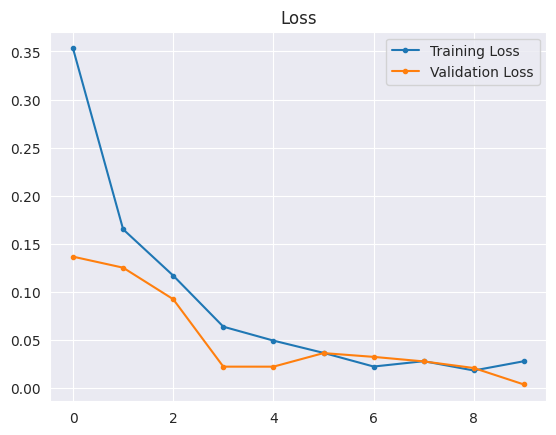

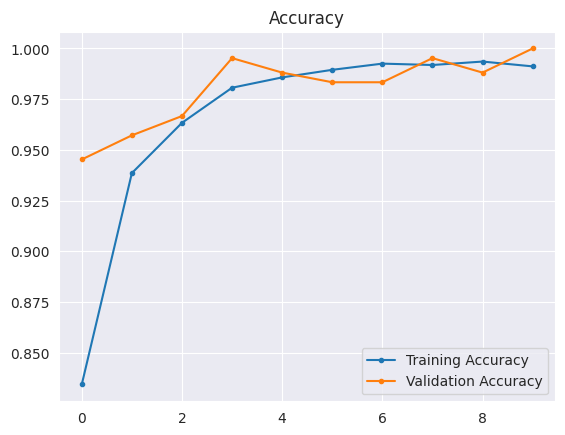

In [14]:
losses = pd.DataFrame(model.history.history)

sns.set_style("darkgrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.legend(['Training Loss', 'Validation Loss'])  # Change legend labels
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()

print("\n")

losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.legend(['Training Accuracy', 'Validation Accuracy'])  # Change legend labels
plt.savefig(f'{file_path}/model_training_acc.png', bbox_inches='tight', dpi=150)
plt.show()
#---------------------------------------------


# Evaluating the created Model 

- 


In [20]:
os.makedirs("outputs/v2/model training/evaluation", exist_ok=True)

model = load_model('outputs/v1/model training/cherry_mildew_model.h5')
loss_accuracy_evaluation = model.evaluate(augmented_test_set)
joblib.dump(value=loss_accuracy_evaluation, filename="outputs/v2/model training/evaluation/model_evaluation.pkl")

#---------------------------------------------

 1/43 [..............................] - ETA: 6s - loss: 2.1109e-05 - accuracy: 1.0000

2023-05-22 14:41:04.615409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


43/43 [==============================] - 1s 13ms/step - loss: 0.0049 - accuracy: 1.0000


['outputs/v2/model training/evaluation/model_evaluation.pkl']

 # Prediction on new data
- Randomly selecting an image, perfoming classification prediction, and displaying the prediction classification, probability, and image file path to check.

Image File Path check: inputs/datasets/cherry-leaves/test/powdery_mildew/b0084869-42c1-4124-853d-d73f99ee8d38___FREC_Pwd.M 4807_flipLR.JPG
Image shape: (256, 256), Image mode: RGB


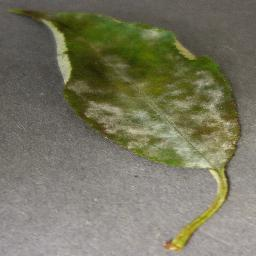

In [248]:
"""
    Checking code for prediction and making image larger to see if it's picking correct images that match the labels "health" or "powdery"
"""
# Select a random label and image
random_label, random_image = random.choice([(label, image) for label in labels for image in os.listdir(test_path + '/' + label)])

# Resize the image
new_image_size = (image_shape[0] * 4, image_shape[1] * 4)
pil_image = image.load_img(os.path.join(test_path, random_label, random_image),
                           target_size=new_image_size, color_mode='rgb')

# Full directory path of the randomly chosen image
image_path = os.path.join(test_path, random_label, random_image)
print("Image File Path check:", image_path)
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image


1/1 [==============================] - 0s 15ms/step
Prediction Classification: powdery_mildew
Probability of Matching Classification: 99.99%
Image File Path check: powdery_mildew/13c13e29-d8eb-4013-9cda-674e92b8d4b4___FREC_Pwd.M 5006_flipLR.JPG


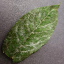

In [259]:
# Select a random label and image
random_label, random_image = random.choice([(label, image) for label in labels for image in os.listdir(test_path + '/' + label)])

# Full directory path of the randomly chosen image
image_path = os.path.join(test_path, random_label, random_image)

# Load and resize the image
pil_image = image.load_img(image_path, target_size=image_shape, color_mode='rgb')
my_image = np.expand_dims(image.img_to_array(pil_image) / 255.0, axis=0)

pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in augmented_train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]
if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

truncated_proba = math.trunc(pred_proba * 100 * 100) / 100
desired_path = '/'.join(image_path.split('/')[4:])

print("Prediction Classification:", pred_class)
print("Probability of Matching Classification: {}%".format(truncated_proba))
print("Image File Path check:", desired_path)
pil_image
#--------------------------


# Summary

#### Objective: Respond to Business Requirement 2 by determining the health status (healthy or powdery mildew) of cherry leaves based on given images.

- Analyzed and visualized the distribution of images in the train, validation, and test sets.
- Prepared augmented image datasets for training, validation, and testing.
- Created a deep learning model for image classification using Convolutional Neural Networks (CNN).
- Trained the model on the augmented training set and evaluated its performance on the augmented validation set.
- Saved the trained model for future use.
- Plotted and analyzed the model's training loss and accuracy.
- Evaluated the model's performance on the augmented test set and saved the evaluation results.
- Made predictions on a randomly selected image using the trained model and displayed the prediction classification, probability, and image information.

### To Fix:
- Code for generating and displaying augmented images from the augmented_train_set is not working"- Fixed by correcting syntax
- loss and val_accuracy don't seem to be good as there is high loss and and low accuracy.
    - Tried increasing augmented data from 2 to 10 range to see if that improves accuracy but did not work.
        - Fixed by correcting the wrong selected columns. Corrected "['loss', 'val_accuracy']" to "['loss', 'val_loss']"
- Code wont run unless I have requirement.txt file ran at the beginning....
- Reduce dataset (Box 10) down from 7 each if possible.